In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

file_path = 'Cleaned_Combined_Data.xlsx'
data = pd.read_excel(file_path)

# Clean column names
data.columns = data.columns.str.strip().str.replace(' ', '_').str.lower()


In [2]:
# Assuming 'registration_year' column exists, remove rows where it's 2024
data = data[data['registration_year'] != 2024]

In [3]:
# Aggregate data by registration year
yearly_sales = data.groupby('registration_year')['vehicle_count'].sum().reset_index()
sales = yearly_sales['vehicle_count'].values
years = yearly_sales['registration_year'].values


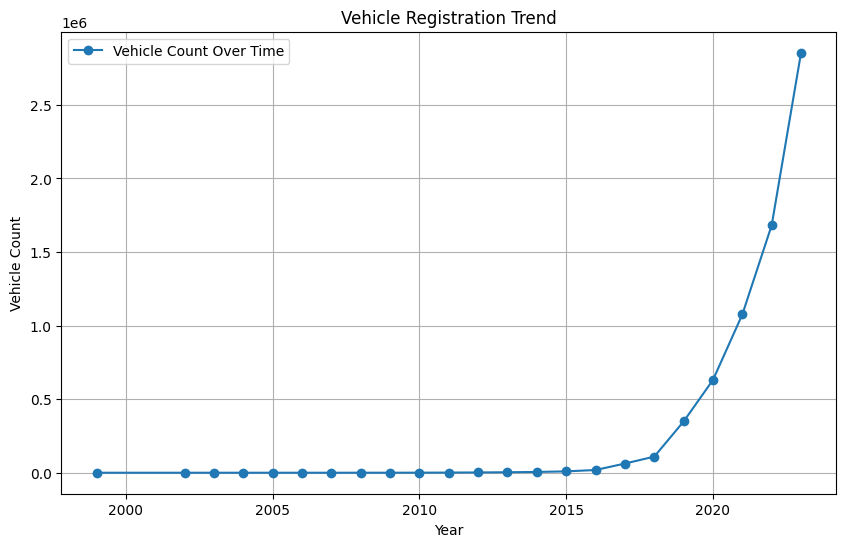

In [4]:
plt.figure(figsize=(10, 6))
yearly_data = data.groupby('registration_year')['vehicle_count'].sum()
plt.plot(yearly_data.index, yearly_data.values, marker='o', label='Vehicle Count Over Time')
plt.title('Vehicle Registration Trend')
plt.xlabel('Year')
plt.ylabel('Vehicle Count')
plt.grid(True)
plt.legend()
plt.show()


<ipython-input-5-aa1500499e6e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_models.values, y=top_models.index, palette='viridis')


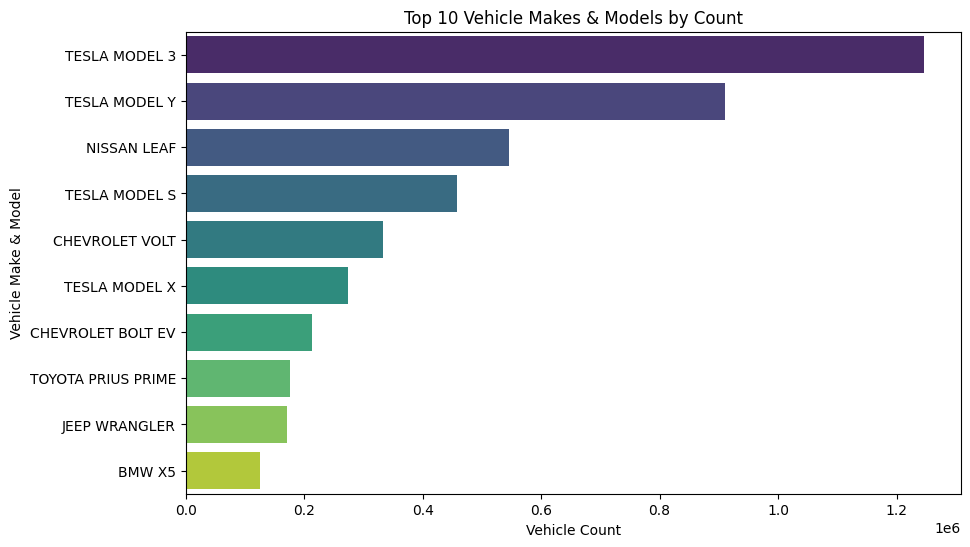

In [5]:
# Bar Plot: Top Vehicle Makes and Models
top_models = data.groupby('vehicle_make_&_model')['vehicle_count'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_models.values, y=top_models.index, palette='viridis')
plt.title('Top 10 Vehicle Makes & Models by Count')
plt.xlabel('Vehicle Count')
plt.ylabel('Vehicle Make & Model')
plt.show()


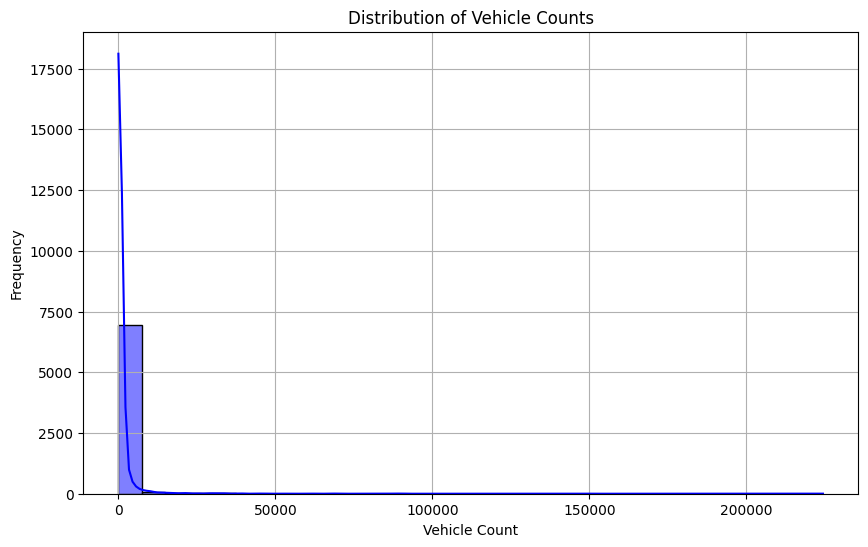

In [6]:
#Histogram: Distribution of Vehicle Counts
plt.figure(figsize=(10, 6))
sns.histplot(data['vehicle_count'], kde=True, bins=30, color='blue')
plt.title('Distribution of Vehicle Counts')
plt.xlabel('Vehicle Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


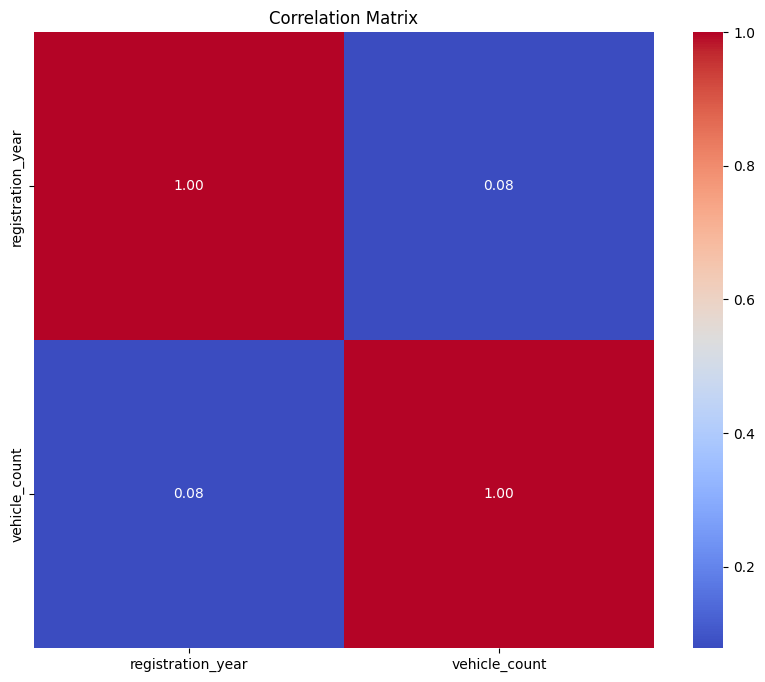

In [7]:
#Correlation Matrix Heatmap
numerical_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [8]:
# Define Bass Diffusion Model
def bass_model(t, p, q, m):
    adoption = m * ((p + q) ** 2 / p) * np.exp(-(p + q) * t) / (1 + (q / p) * np.exp(-(p + q) * t)) ** 2
    return adoption

# Define Generalized Bass Model
def generalized_bass_model(t, p, q, m, g=1.0):
    adoption = g * m * ((p + q) ** 2 / p) * np.exp(-(p + q) * t) / (1 + (q / p) * np.exp(-(p + q) * t)) ** 2
    return adoption


In [9]:
# Fit Bass Model
initial_params_bass = [0.01, 0.4, max(sales) * 2]  # Initial guesses for p, q, m
params_bass, _ = curve_fit(
    lambda t, p, q, m: bass_model(t - min(years), p, q, m),
    years, sales, p0=initial_params_bass, maxfev=10000
)

# Fit Generalized Bass Model (GBM)
initial_params_gbm = [0.01, 0.4, max(sales) * 2, 1.0]
params_gbm, _ = curve_fit(
    lambda t, p, q, m, g: generalized_bass_model(t - min(years), p, q, m, g),
    years, sales, p0=initial_params_gbm, maxfev=10000
)


In [10]:
# Simulate parameter uncertainty for the Bass Model
np.random.seed(42)
simulations = 100
p_vals = np.random.normal(params_bass[0], 0.005, simulations)
q_vals = np.random.normal(params_bass[1], 0.05, simulations)
m_vals = np.random.normal(params_bass[2], params_bass[2] * 0.1, simulations)

forecasted_uncertain = []
future_years = np.arange(years[-1] + 1, years[-1] + 6)  # Forecast next 5 years
for p, q, m in zip(p_vals, q_vals, m_vals):
    forecasted_uncertain.append(bass_model(future_years - min(years), p, q, m))
forecasted_uncertain = np.array(forecasted_uncertain)


In [11]:
forecast_bass = bass_model(future_years - min(years), *params_bass)
forecast_gbm = generalized_bass_model(future_years - min(years), *params_gbm)
forecast_uncertain_mean = forecasted_uncertain.mean(axis=0)
forecast_uncertain_lower = forecasted_uncertain.min(axis=0)
forecast_uncertain_upper = forecasted_uncertain.max(axis=0)


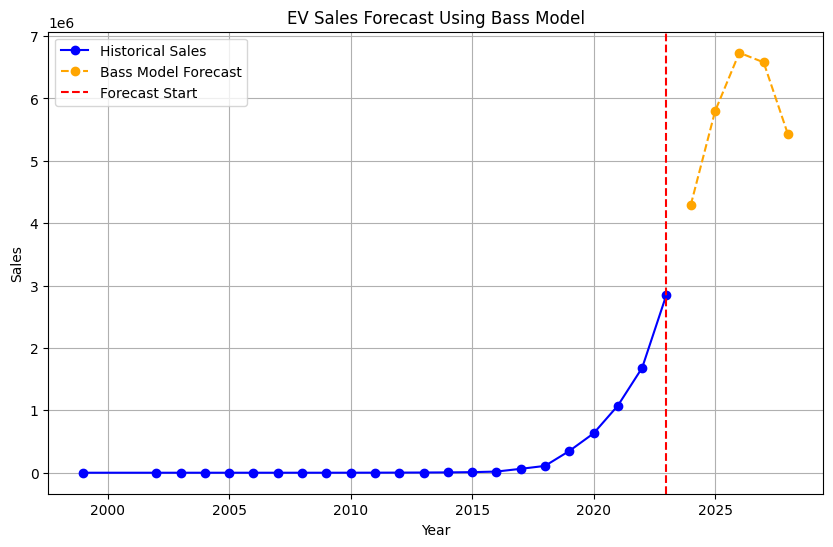

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(years, sales, marker='o', label='Historical Sales', color='blue')
plt.plot(future_years, forecast_bass, marker='o', linestyle='--', color='orange', label='Bass Model Forecast')
plt.axvline(x=years[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('EV Sales Forecast Using Bass Model')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


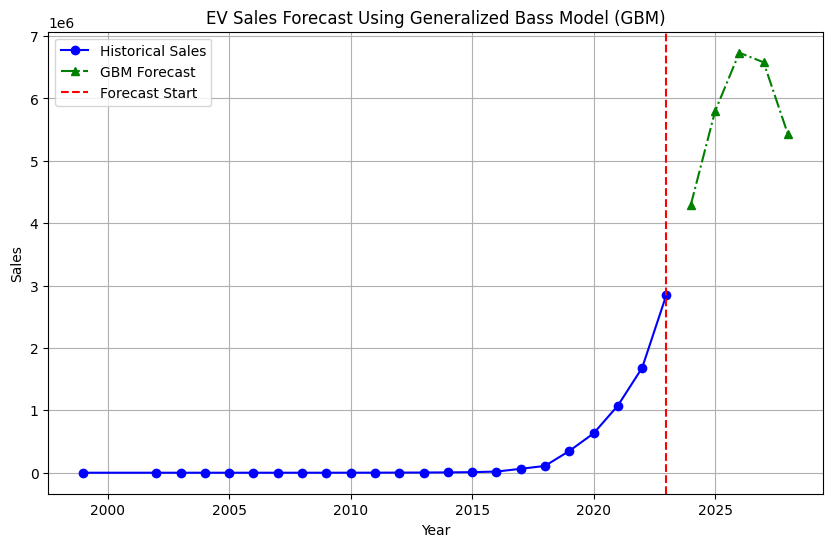

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(years, sales, marker='o', label='Historical Sales', color='blue')
plt.plot(future_years, forecast_gbm, marker='^', linestyle='-.', color='green', label='GBM Forecast')
plt.axvline(x=years[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('EV Sales Forecast Using Generalized Bass Model (GBM)')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


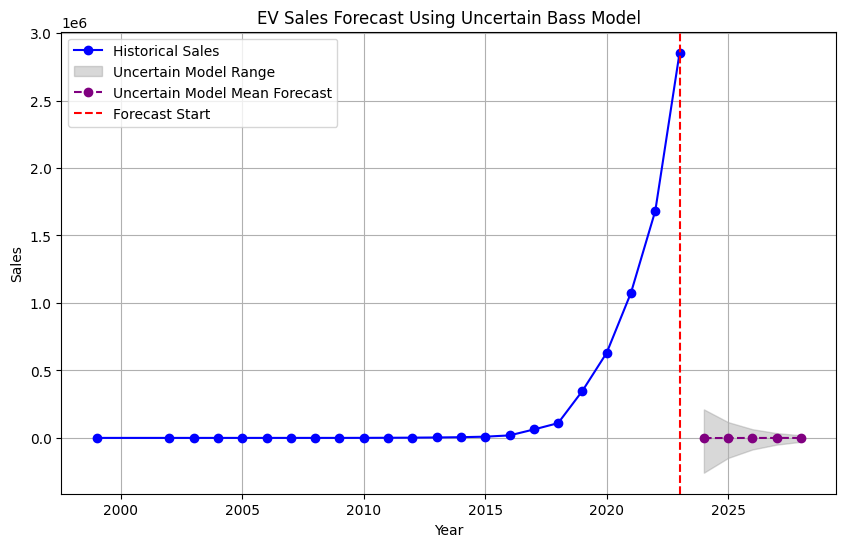

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(years, sales, marker='o', label='Historical Sales', color='blue')
plt.fill_between(
    future_years,
    forecast_uncertain_lower,
    forecast_uncertain_upper,
    color='gray', alpha=0.3, label='Uncertain Model Range'
)
plt.plot(future_years, forecast_uncertain_mean, marker='o', linestyle='--', color='purple', label='Uncertain Model Mean Forecast')
plt.axvline(x=years[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('EV Sales Forecast Using Uncertain Bass Model')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
forecast_df = pd.DataFrame({
    'Year': future_years,
    'Bass_Model_Forecast': forecast_bass,
    'GBM_Forecast': forecast_gbm,
    'Uncertain_Bass_Mean': forecast_uncertain_mean,
    'Uncertain_Bass_Lower': forecast_uncertain_lower,
    'Uncertain_Bass_Upper': forecast_uncertain_upper,
})
print(forecast_df)


   Year  Bass_Model_Forecast  GBM_Forecast  Uncertain_Bass_Mean  \
0  2024         4.290145e+06  4.290124e+06         -1181.798814   
1  2025         5.793054e+06  5.792971e+06          -740.884955   
2  2026         6.732331e+06  6.732139e+06          -466.193664   
3  2027         6.578454e+06  6.578151e+06          -292.610801   
4  2028         5.425413e+06  5.425067e+06          -182.768808   

   Uncertain_Bass_Lower  Uncertain_Bass_Upper  
0        -258001.815240         211315.825724  
1        -148554.532184         116778.758228  
2         -85845.310409          64346.988156  
3         -49711.025939          35399.243106  
4         -28821.269435          19456.975285  


In [16]:
from scipy.stats import t

# Fit the Bass Model to get parameters and covariance matrix
params_bass, cov_bass = curve_fit(
    lambda t, p, q, m: bass_model(t - min(years), p, q, m),
    years, sales,
    p0=initial_params_bass,
    maxfev=10000
)

# Extract standard errors from the diagonal of the covariance matrix
std_errors_bass = np.sqrt(np.diag(cov_bass))

# Perform hypothesis testing
print("Hypothesis Testing for Bass Model Parameters:")
for param, std_err, param_name in zip(params_bass, std_errors_bass, ['p', 'q', 'm']):
    t_stat = param / std_err  # t-statistic
    p_value = 2 * (1 - t.cdf(abs(t_stat), df=len(sales) - len(params_bass)))  # Two-tailed p-value
    print(f"{param_name}: t-stat = {t_stat:.4f}, p-value = {p_value:.4e}")


Hypothesis Testing for Bass Model Parameters:
p: t-stat = 2.9709, p-value = 7.5543e-03
q: t-stat = 19.3645, p-value = 1.9984e-14
m: t-stat = 2.7762, p-value = 1.1653e-02


Key Findings:

Innovation Coefficient (p):

The t-statistic is 2.9709, and the p-value is 0.0075543, which is below the typical significance threshold (α=0.05).
Conclusion: The innovation coefficient
𝑝
p is statistically significant. This suggests that external influences, such as marketing efforts or early adopters' behavior, play a notable role in the adoption dynamics reflected in this dataset.


Imitation Coefficient (q):

The t-statistic is 19.3645, and the p-value is 1.9984e-14, which is significantly lower than 0.05.
Conclusion: The imitation coefficient
𝑞
q is highly statistically significant. This indicates that social influence, such as word-of-mouth or peer adoption, is a dominant factor driving adoption within this dataset.


Market Potential (m):

The t-statistic is 2.7762, and the p-value is 0.011653, which is well below 0.05.
Conclusion: The market potential
𝑚
m is statistically significant. This confirms that the total number of potential adopters is a critical and meaningful parameter in the Bass model for this dataset.

In [17]:
# Define functions for AIC and BIC calculation
def calculate_aic(n, rss, k):
    return n * np.log(rss / n) + 2 * k

def calculate_bic(n, rss, k):
    return n * np.log(rss / n) + k * np.log(n)

# Calculate RSS (Residual Sum of Squares) for both models
rss_bass = np.sum((sales - bass_model(years - min(years), *params_bass)) ** 2)
rss_gbm = np.sum((sales - generalized_bass_model(years - min(years), *params_gbm)) ** 2)

# AIC and BIC for the Bass Model
aic_bass = calculate_aic(len(sales), rss_bass, len(params_bass))
bic_bass = calculate_bic(len(sales), rss_bass, len(params_bass))

# AIC and BIC for the GBM
aic_gbm = calculate_aic(len(sales), rss_gbm, len(params_gbm))
bic_gbm = calculate_bic(len(sales), rss_gbm, len(params_gbm))

# Compare results
print("\nModel Comparison:")
print(f"Bass Model: AIC = {aic_bass:.2f}, BIC = {bic_bass:.2f}")
print(f"GBM: AIC = {aic_gbm:.2f}, BIC = {bic_gbm:.2f}")



Model Comparison:
Bass Model: AIC = 477.49, BIC = 480.90
GBM: AIC = 479.49, BIC = 484.03


The values indicate the following for the model comparison:

Interpreting AIC and BIC:
Akaike Information Criterion (AIC):

Measures the goodness of fit of the model while penalizing the number of parameters.
Lower AIC values indicate a better model, considering both fit and complexity.
Result: The Bass Model has a lower AIC (477.49) compared to GBM (479.49), indicating that the Bass Model is a slightly better fit.
Bayesian Information Criterion (BIC):

Similar to AIC but penalizes model complexity more strongly.
Lower BIC values indicate a better model.
Result: The Bass Model has a lower BIC (480.90) compared to GBM (484.03), reinforcing that the Bass Model is a better fit.